In [227]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import gridspec
import sys
import pandas as pd
import seaborn as sns
import networkx as nx
import yaml
import os
from networkx.algorithms import approximation as nx_approx
from tqdm.notebook import tqdm
from copy import deepcopy
# Adding path to module
sys.path.append("../")
# picture path
PICS = '../pics/'
import scipy.stats
# Module imports
from contagion import Contagion, config
from contagion.config import _baseconfig
from contagion.plotting import plot_infection_history
from contagion.pdfs import construct_pdf
from distributed import Client
import itertools
from matplotlib.backends.backend_pdf import PdfPages
from time import sleep
import pickle
from glob import glob

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


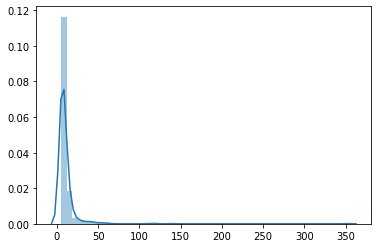

In [200]:
a = construct_pdf({
            "class": "Pareto",
            "x_min": 5,
            "index": 2,
        })
sns.distplot(a.rvs(1000))


In [199]:
10 * (2-1) / 2

5.0

In [202]:
np.average(a.rvs(10000))

9.945496448463997

In [220]:
cpp_config = {
    "DaysBackwardTrace": 7, 
    "TestPositiveProbability": 0.9, 
    "OutputPrefix": "CovidMC_1346", 
    "AppProbability": 1.0, 
    "DaysToTestResult": 0, 
    "FalsePositiveRate": 0.00, 
    "NDays": 500, 
    "SymptomProbability": 0.6, 
    "SocialDistancingFactor": 1.0, 
    "SocialDistancingTo": 99999, 
    "BackwardTracing": True, 
    "dTTest": 5, 
    "PeopleMetPerDay": 10.0, 
    "DaysInQuarantine": 14, 
    "TraceUninfected": True, 
    "AsymptomaticTransmissionScaling": 1.0, 
    "StartTracingTestingInfectedFraction": 0.004, 
    "SocialDistancingFrom": 99999, 
    "TransmissionProbability": 0.0287, 
    "NPersons": 100000, 
    "TracingOrder": 1, 
    "IncubationPeriod": {
        "mu": 0, 
        "beta": 2.44, 
        "gamma": 3.06
    }, 
    "TestThreshold": 0.01, 
    "tracingEfficiency": 1.0, 
    "SocialDistancingMaxPeople": 60, 
    "Infectivity": {
        "mu": -2.42, 
        "beta": 1.56, 
        "gamma": 2.08
    }, 
    "TracingDelay": 0, 
    "ReportingProbability": 1.0
}

cpp_config_bm3 = {
    "OutputPrefix": "CovidMCResult",
    "NPersons": 10000,
    "NDays": 500,
    "PeopleMetPerDay": 5,
    "SymptomProbability": 0.5,
    "TransmissionProbability": 0.0595,
    "DaysInQuarantine": 14,
    "TracingOrder": 1,
    "DaysBackwardTrace": 14,
    "StartTracingTestingInfectedFraction": 0.0001,
    "BackwardTracing": False,
    "TraceUninfected": False,
    "AppProbability": 0.7,
    "DaysToTestResult": 0,
    "TestThreshold":0.01,
    "TestPositiveProbability": 0.0,
    "dTTest": 5,
    "FalsePositiveRate": 0.00,
    "SocialDistancingFactor": 1.0,
    "IncubationPeriod": {
	"mu": 0,
	"gamma": 3.06,
	"beta": 2.44
    },
    "Infectivity": {
	"mu": -2.42,
	"gamma": 2.08,
	"beta": 1.56
    }
}

cpp_config_default_noint = {
    "DaysBackwardTrace": 7, 
    "TestPositiveProbability": 0.9, 
    "OutputPrefix": "CovidMC_1346", 
    "AppProbability": 0, 
    "DaysToTestResult": 0, 
    "FalsePositiveRate": 0.00, 
    "NDays": 500, 
    "SymptomProbability": 0.6, 
    "SocialDistancingFactor": 1.0, 
    "SocialDistancingTo": 99999, 
    "BackwardTracing": True, 
    "dTTest": 5, 
    "PeopleMetPerDay": 10.0, 
    "DaysInQuarantine": 14, 
    "TraceUninfected": False, 
    "AsymptomaticTransmissionScaling": 1.0, 
    "StartTracingTestingInfectedFraction": 0.004, 
    "SocialDistancingFrom": 99999, 
    "TransmissionProbability": 0.0287, 
    "NPersons": 100000, 
    "TracingOrder": 1, 
    "IncubationPeriod": {
        "mu": 0, 
        "beta": 2.44, 
        "gamma": 3.06
    }, 
    "TestThreshold": 0.01, 
    "tracingEfficiency": 1.0, 
    "SocialDistancingMaxPeople": 60, 
    "Infectivity": {
        "mu": -2.42, 
        "beta": 1.56, 
        "gamma": 2.08
    }, 
    "TracingDelay": 0, 
    "ReportingProbability": 1.0
}




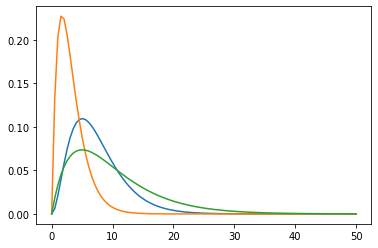

In [171]:
xs = np.linspace(0, 50, 100)
plt.plot(xs, incub_pdf.pdf(xs))
plt.plot(xs, infect_pdf.pdf(xs))
plt.plot(xs, ppl_met_per_day_pdf.pdf(xs))

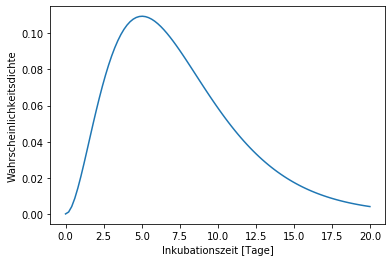

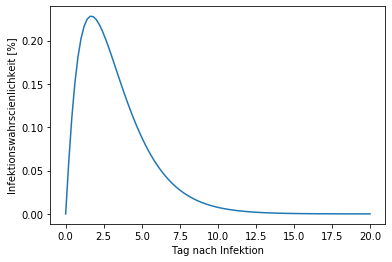

In [168]:
xs = np.linspace(0, 20, 100)
plt.plot(xs, incub_pdf.pdf(xs))
plt.xlabel("Inkubationszeit [Tage]")
plt.ylabel("Wahrscheinlichkeitsdichte")
plt.savefig("inkubationszeit.png", dpi=150)

plt.figure()
plt.plot(xs, infect_pdf.pdf(xs))
plt.xlabel("Tag nach Infektion")
plt.ylabel("Infektionswahrscienlichkeit [%]")
plt.savefig("infectionswkeit.png", dpi=150)

In [14]:
a = np.array([0])
print(type(a[0].item()))

<class 'int'>


In [216]:
def cpp_config_to_python(cpp_config):
    
    incub_pdf = scipy.stats.gamma(cpp_config["IncubationPeriod"]["gamma"], scale=cpp_config["IncubationPeriod"]["beta"])
    infect_pdf = scipy.stats.gamma(
        cpp_config["Infectivity"]["gamma"],
        scale=cpp_config["Infectivity"]["beta"],
        )

    ppl_met_per_day_pdf = scipy.stats.gamma(2, scale=cpp_config["PeopleMetPerDay"]/2)
    
    my_config = deepcopy(_baseconfig)

    my_config["general"]["random state seed"] = 6
    my_config["general"]["track graph history"] = True
    my_config["general"]["debug level"] = 50
    my_config["general"]["trace spread"] = True
    my_config["general"]["config location"] = "config.yaml"
    my_config["general"]["log file handler"] = "contagion.log"
    my_config["population"]["population class"] = "NetworkXPopulation"
    my_config["population"]["population storage"] = "population.pickle"
    #my_config["population"]["population class"] = "HomogeneousPopulation"
    my_config["population"]["social circle interactions pdf"] = {
        "class": "Gamma",
        "mean": ppl_met_per_day_pdf.mean(),
        "sd": ppl_met_per_day_pdf.std(),
        "upper": 60
    }
    my_config["population"]["social circle pdf"] = {
        "class": "Gamma",
        "mean": ppl_met_per_day_pdf.mean(),
        "sd": ppl_met_per_day_pdf.std(), 
        "upper": 60
    }

    my_config["measures"]["contact tracing"] = True
    my_config["measures"]["tracked fraction"] = 0 #cpp_config["AppProbability"]
    my_config["measures"]["second order"] = cpp_config["TracingOrder"] == 2
    my_config["measures"]["backtrack length"] = cpp_config["DaysBackwardTrace"]+1
    my_config["measures"]["track uninfected"] = cpp_config["TraceUninfected"]
    my_config["measures"]["quarantine"] = True
    my_config["measures"]["report symptomatic"] = True
    my_config["measures"]["quarantine duration"] = cpp_config["DaysInQuarantine"]
    my_config["measures"]["testing"] = True
    my_config["measures"]["time until test"] = 0
    my_config["measures"]["time until result"] = cpp_config["DaysToTestResult"]
    my_config["measures"]["time until second test"] = cpp_config["dTTest"]+1
    my_config["measures"]["time until second test result"] = 0
    my_config["measures"]["test true positive rate"] = cpp_config["TestPositiveProbability"]
    my_config["measures"]["test false positive rate"] = cpp_config["FalsePositiveRate"]
    my_config["measures"]["test threshold"] = cpp_config["TestThreshold"]
    my_config["measures"]["app fraction"] = cpp_config["AppProbability"]

    my_config["scenario"]["sim_length"] = 500
    my_config['infection']['infected'] = 1
    my_config["infection"]["infection probability pdf"] = {
        "class": "Gamma",
        "scaling": (infect_pdf.ppf(0.99))*cpp_config["TransmissionProbability"],
        "mean":  infect_pdf.mean(),
        "sd":  infect_pdf.std()
    }
    my_config['infection']["hospitalization probability pdf"] = {
        'mean':  0,
        "class": "Delta"
    }
    my_config['infection']['will have symptoms prob pdf'] = {
        'mean': cpp_config["SymptomProbability"],
        "class": "Delta"
    }


    my_config["infection"]["infectious duration pdf"] = {
        "mean": np.round(infect_pdf.ppf(0.99)),
        "class": "Delta"
    }

    my_config["infection"]["latency duration pdf"] = {
        #"mean": -cpp_config["Infectivity"]["mu"],
        #"class": "Delta"
        "upper": np.ceil(-cpp_config["Infectivity"]["mu"]),
        "lower": np.floor(-cpp_config["Infectivity"]["mu"]),
        "class": "Uniform"
    }

    my_config["infection"]["incubation duration pdf"]["mean"] = incub_pdf.mean()
    my_config["infection"]["incubation duration pdf"]["sd"] = incub_pdf.std()
    my_config["infection"]["incubation duration pdf"]["as_dtype"] = np.int


    my_config["population"]["random interactions pdf"] = {
        "mean": 0.0,
        "class": "Delta"
    }

    my_config["population"]["random interactions intensity pdf"]= {
        "mean": 0.0,
        "class": "Delta"
    }

    my_config["infection"]["recovery time pdf"]= {
        "class": "Delta",
        "mean": 0,
    }

    my_config["population"]["population size"] = cpp_config["NPersons"]

    my_config["population"]["nx"]["func"] = "lfr_ba"
    my_config["population"]["nx"]["kwargs"] = {
                    "m": 3,
                    "tau": 1.2,
                    "mu": 0.1,
                    "min_community": 13,
                    #"max_community": 40,
                    "max_iters": 4000,
                    "tolerance": 0.1,
                    "pref_attach": True
    }
    my_config["population"]["nx"]["inter freq pdf"] = {
        "mean": cpp_config["PeopleMetPerDay"],
        "class": "Gamma",
        "mean": ppl_met_per_day_pdf.mean(),
        "sd": ppl_met_per_day_pdf.std(), 
    }
    my_config["population"]["nx"]["intra freq pdf"] = {
        "mean": cpp_config["PeopleMetPerDay"],
        "class": "Gamma",
        "mean": ppl_met_per_day_pdf.mean(),
        "sd": ppl_met_per_day_pdf.std(), 
    }
    my_config["population"]["random interactions pdf"] = {"class": "Delta", "mean": 0.000}
    my_config["scenario"]["class"] = "LateMeasures"
    my_config["scenario"]["start_measures_inf_frac"] = cpp_config["StartTracingTestingInfectedFraction"]
    my_config["scenario"]["contact_scaling"] = cpp_config["SocialDistancingFactor"]
    my_config["population"]["nx"]["kwargs"]["school_symp_prob"] = symp_prob

    ppl_met_per_day_dist_pdf = scipy.stats.gamma(2, scale=my_config["scenario"]["contact_scaling"]*cpp_config["PeopleMetPerDay"]/2)
    if cpp_config["StartTracingTestingInfectedFraction"] < 0:
        my_config["scenario"]["social_dist_contact_pdf"] = {
            "class": "Gamma",
            "mean": ppl_met_per_day_dist_pdf.mean(),
            "sd": ppl_met_per_day_dist_pdf.std(),
            "upper": 15
        }
    else:
        my_config["scenario"]["social_dist_contact_pdf"] = None
        
    return my_config
    

In [224]:
my_config = cpp_config_to_python(cpp_config)
bm3_config = cpp_config_to_python(cpp_config_bm3)
bm3_config["population"]["population class"] = "HomogeneousPopulation"
bm3_config["measures"]["rnd testing"] = False
yaml.dump(bm3_config, open("bm3_config.yaml", "w"))

In [139]:
yaml.dump(my_config, open("test_social_graph_cpp_params.yaml", "w"))

In [140]:
def calc_single(conf):
    contagion = Contagion(conf)
    contagion.sim()
    
    # R0 calc
    inf_hist = np.atleast_2d(np.squeeze(np.hstack(contagion.trace_infection)))
    if len(inf_hist) > 0:
        patient_zero = inf_hist[0, 0]
        n_inf = (inf_hist[:, 0] == patient_zero).sum()
    else:
        n_inf = 0
    

    _, inf_per_inf = np.unique(inf_hist[:, 0], return_counts=True)
    
    
    return pd.DataFrame(contagion.statistics), n_inf, inf_per_inf
    

In [107]:
def sim_config(conf, n=10):
    if not os.path.exists(conf["population"]["population storage"]):
        conf["population"]["store population"] = True
        #my_config["population"]["population storage"] = "1E6_lfr_ba.pickle"
        conf["population"]["re-use population"] = False
        contagion = Contagion(conf)
    conf["population"]["re-use population"] = True
    conf["population"]["store population"] = False
    
    results = []
    for i in range(n):
        conf["general"]["random state seed"] = i
        results.append(calc_single(conf))
    return results

    

In [209]:
conf_1 = deepcopy(my_config)
conf_1["population"]["population class"] = "HomogeneousPopulation"


conf_2 = deepcopy(my_config)
conf_2["population"]["population class"] = "NetworkXPopulation"
conf_2["population"]["nx"]["func"] = "lfr_ba"
conf_2["population"]["nx"]["kwargs"]["m"] = 3

conf_3 = deepcopy(my_config)
conf_3["population"]["population class"] = "NetworkXPopulation"
conf_3["population"]["nx"]["func"] = "lfr_ba"
conf_3["population"]["nx"]["kwargs"]["m"] = 4

conf_4 = deepcopy(my_config)
conf_4["population"]["population class"] = "NetworkXPopulation"
conf_4["population"]["nx"]["func"] = "lfr_ba"
conf_4["population"]["nx"]["kwargs"]["m"] = 5
conf_4["population"]["nx"]["kwargs"]["mu"] = 0.1

conf_5 = deepcopy(my_config)
conf_5["population"]["population class"] = "NetworkXPopulation"
conf_5["population"]["nx"]["func"] = "hierarchical_lfr_ba"
conf_5["population"]["nx"]["kwargs"]["m"] = 3
conf_5["population"]["nx"]["kwargs"]["mu_hier"] = 0.3
conf_5["population"]["nx"]["kwargs"]["tau_graphs"]= 3
conf_5["population"]["nx"]["kwargs"]["min_graph"] = 5000
conf_5["population"]["nx"]["kwargs"]["max_graph"] = 200000
conf_5["population"]["nx"]["kwargs"]["max_iters"] = 50000

conf_6 = deepcopy(my_config)
conf_6["population"]["population class"] = "NetworkXPopulation"
conf_6["population"]["nx"]["func"] = "lfr_ba"
conf_6["population"]["nx"]["kwargs"]["m"] = 5
conf_6["population"]["nx"]["kwargs"]["mu"] = 0.5

conf_7 = deepcopy(my_config)
conf_7["population"]["population class"] = "HomogeneousPopulation"
conf_7["population"]["social circle interactions pdf"] = {
    "class": "Pareto",
    "x_min": 5,
    "index": 2}


configs = [conf_1, conf_2, conf_3, conf_4, conf_5, conf_6, conf_7]



In [117]:
import cProfile


In [118]:
conf_test = deepcopy(conf_1)
conf_test["population"]["population size"] = 100000
conf_test["population"]["re-use population"] = False
conf_test["general"]["trace states"] = False
conf_test["general"]["random state seed"] = 7
conf_test["measures"]["rnd testing"] = False
conf_test["measures"]["random test num"] = 10
#conf_test["measures"]["quarantine"] = False
#conf_test["measures"]["conact tracing"] = False
contagion = Contagion(conf_test)
contagion.sim()
stats = pd.DataFrame(contagion.statistics)

In [81]:
tr_inf = np.hstack(contagion.trace_infection).squeeze()

_, cnt = np.unique(tr_inf[:, 0], return_counts=True)

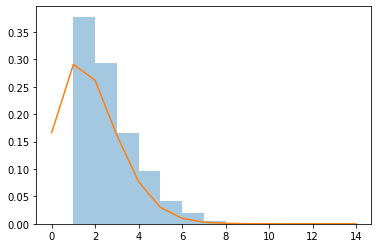

In [82]:
sns.distplot(cnt, bins=np.arange(15), kde=False, norm_hist=True)

xs = np.arange(15)
plt.plot(xs, scipy.stats.nbinom.pmf(xs, n=35, p=0.95))

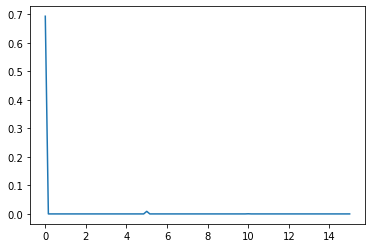

In [51]:
plt.plot(xs, scipy.stats.nbinom.pmf(xs, n=0.4, p=0.4))

In [36]:
#data_cpp = pd.read_csv("Sum_CovidSimMC_1346.csv")

(0, 500)

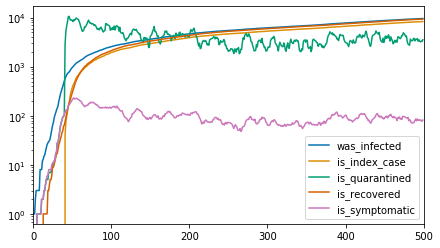

In [119]:
plt.figure(figsize=(7, 4))
colors = sns.color_palette("colorblind", 8)

fields = ["was_infected", "is_index_case", "is_quarantined", "is_recovered", "is_symptomatic"]

for field, color in zip(fields, colors):
    plt.plot(stats[field], color=color, label=field)
plt.legend()
plt.semilogy()
plt.xlim(0, 500)

In [55]:
df = pd.DataFrame(contagion.traced_states[58])
df.loc[df["is_index_case"] & ~df["was_infected"] , ["is_quarantined", "is_tested", "is_tested_negative", "is_tested_second", "time_until_second_test",
                              "is_tested_negative_second", "time_since_last_test_result", "has_second_test_result", "is_tested_positive_second",
                              "is_tested_second", "was_infected"]]

,is_quarantined,is_tested,is_tested_negative,is_tested_second,time_until_second_test,is_tested_negative_second,time_since_last_test_result,has_second_test_result,is_tested_positive_second,is_tested_second,was_infected


(0, 500)

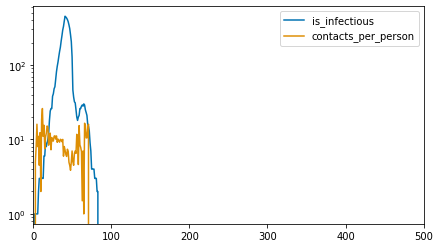

In [27]:
plt.figure(figsize=(7, 4))
colors = sns.color_palette("colorblind", 8)

fields = ["is_infectious", "contacts_per_person"]

for field, color in zip(fields, colors):
    plt.plot(stats[field], color=color, label=field)
plt.legend()
plt.semilogy()
plt.xlim(0, 500)

(0, 100)

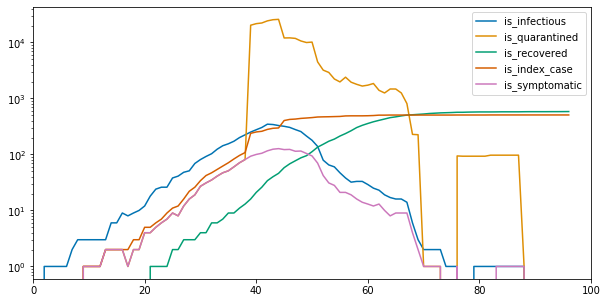

In [168]:
plt.figure(figsize=(10, 5))
colors = sns.color_palette("colorblind", 8)

fields = ["is_infectious", "is_quarantined", "is_recovered", "is_index_case", "is_symptomatic"]

for field, color in zip(fields, colors):
    plt.plot(stats[field], color=color, label=field)
plt.legend()
plt.semilogy()
"""
plt.plot(data_cpp["day"], data_cpp[" fNInfectious"], color="b", alpha=0.2, )
plt.plot(data_cpp["day"], data_cpp[" fNQuarantineToday"], color="r", alpha=0.2, lw=1)
plt.plot(data_cpp["day"], data_cpp[" fNReported"], color="g", alpha=0.2)
"""
plt.xlim(0, 100)


In [169]:
stats.to_csv("contagion_benchmark.csv")

In [9]:
def plot_scan(all_results, labels, rows=3, cols=4):
    fig = plt.figure(figsize=(15, 10))
    colors = sns.color_palette("colorblind", 4)
    gs = gridspec.GridSpec(rows, cols, hspace=0.3)
    for i, (results, label) in enumerate(zip(all_results, labels)):

        gs_spec = gs[i // cols, i % cols]

        gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, gs_spec, height_ratios=[3, 1], hspace=0.3)
        ax = fig.add_subplot(gs2[0])
        ax2 = fig.add_subplot(gs2[1])

        for result in results:
            ax.plot(result["is_infected"], color=colors[0])
            ax.plot(result["is_recovered"], color=colors[1])
            ax.plot(result["is_quarantined"], color=colors[2])
            ax.plot(result["is_index_case"], color=colors[3])
            ax2.plot(result["Re"], color="k", alpha=0.3)

        ax2.set_xlabel("Time [days]")
        ax.set_title(label)
        ax.set_ylim(1, 1E5)
        ax.set_xlim(0, 500)
        ax.set_yscale("log")

        ax2.set_xlim(0, 500)
        ax2.set_ylim(0, 4)
        ax2.set_ylabel("$R_e$")
        ax2.axhline(1, color="r", lw=2)

    labels = ["Infected", "Recovered", "Quarantined", "Index Cases"]
    proxies = [Line2D([], [], color=color) for color in colors]
    fig.legend(proxies, labels, loc="upper center", ncol=4)
    return fig

def plot_avg_re_scan(all_results, labels, rows=3, cols=4):
    fig = plt.figure(figsize=(15, 10))
    colors = sns.color_palette("colorblind", 4)
    gs = gridspec.GridSpec(rows, cols, hspace=0.3)
    for i, (results, label) in enumerate(zip(all_results, labels)):

        gs_spec = gs[i // cols, i % cols]

        ax = fig.add_subplot(gs_spec)
        
        avg_res = []
        for result in results:
            
            trigger = result["is_infected"].values / 1E5 > 0.004
            
            if np.any(trigger):            
                t_start = np.argwhere(trigger)[0][0]+10
                t_stop = min(t_start+18, len(result))
                avg_res.append(np.average(result["Re"].values[t_start:t_stop]))
           
        ax.set_xlim(0, 2.5)
        sns.distplot(avg_res, ax=ax)
        ax.set_xlabel("Avg. Re")
        ax.set_title(label)
    return fig

   

    

Client Scheduler: tcp://10.152.133.30:35247 Dashboard: http://10.152.133.30:8787/status,Cluster Workers: 58 Cores: 58 Memory: 116.00 GB


In [87]:
conf = deepcopy(conf_1)
conf["population"]["re-use population"] = True
conf["population"]["store population"] = False
conf["general"]["random state seed"] = 1
contagion = Contagion(conf)
contagion.sim()
stats = pd.DataFrame(contagion.statistics)


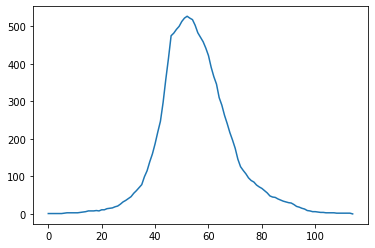

In [88]:
plt.plot(stats["is_infected"])

In [174]:
#!rm /scratch4/chaack/data/contagion/runs/2/configs/*
!rm ../populations/*

In [235]:
outpath = "/scratch4/chaack/data/contagion/runs/11/configs"


if not os.path.exists(outpath):
    os.makedirs(outpath)
    
rnd_test_probs = [0] #[0, 0.05, 0.2]
app_fractions = [0, 0.6, 0.75, 1]
#sdist_scalings = [1, 0.8, 0.6]
sdist_scalings = [1]
symp_probs = [0.6] #[0.6, 0.95]
tracing_efficiencies = [1] # [0.5, 1]
n_persons = [10000, 100000, 1000000]

config_nums = [0, 3, 6]

prod_it = itertools.product(
    config_nums,
    app_fractions,
    rnd_test_probs,
    sdist_scalings,
    symp_probs,
    tracing_efficiencies,
    n_persons)


for i, (config_num, app_frac, rnd_test_prob, sd_scaling, symp_prob, tr_eff, n_person) in enumerate(prod_it):
    config = configs[config_num]
    conf = deepcopy(config)
    conf["measures"]["contact tracing"] = app_frac != 0
    conf["measures"]["app fraction"] = app_frac
    conf["measures"]["rnd testing"] = rnd_test_prob != 0
    conf["measures"]["random test num"] = int(rnd_test_prob * conf["population"]["population size"])
    conf["measures"]["test false positive rate"] = 0
    conf["measures"]["backtrack length"] = 7
    conf["measures"]["tracing efficiency"] = tr_eff
    conf["population"]["population size"] = n_person
    conf["population"]["population storage"] = "/scratch4/chaack/data/contagion/pop_{}_{}.pickle".format(config_num, n_person)
    if sd_scaling < 1:
        ppl_met_per_day_dist_pdf = scipy.stats.gamma(2, scale=sd_scaling*cpp_config["PeopleMetPerDay"]/2)
        conf["scenario"]["social_dist_contact_pdf"] = {
            "class": "Gamma",
            "mean": ppl_met_per_day_dist_pdf.mean(),
            "sd": ppl_met_per_day_dist_pdf.std(),
            "upper": 15
        }
    conf["population"]["nx"]["kwargs"]["symp_prob"] = symp_prob
    conf['infection']['will have symptoms prob pdf'] = {
        'mean': symp_prob,
        "class": "Delta"
    }
    
    conf["population"]["re-use population"] = True
    conf["population"]["store population"] = True

    if not os.path.exists(conf["population"]["population storage"]):
        print("Pre building")
        _ = Contagion(conf)
   
    
        
    yaml.dump(conf, open(os.path.join(outpath, "config_{}.yaml".format(i)), "w"))
        

Pre building
Pre building
Pre building
Pre building
Pre building
Pre building
Pre building
Pre building
Pre building


In [236]:
data = []
prod_it = itertools.product(
    config_nums,
    app_fractions,
    rnd_test_probs,
    sdist_scalings,
    symp_probs,
    tracing_efficiencies,
    n_persons)
for i, (config_num, app_frac, rnd_test_prob, sd_scaling, symp_prob, tr_eff, n_person) in enumerate(prod_it):
    infiles = glob("/scratch4/chaack/data/contagion/runs/11/config_{}_*".format(i))

    stats = []
    # if n_person == 1E6:
    #    continue
    for infile in infiles:
        stats += pickle.load(open(infile, "rb"))["results"]
        
    
    res = {
        "config": config_num,
        "app_frac": app_frac,
        "rnd_test_prob": rnd_test_prob,
        "sd_scaling": sd_scaling,
        "symp_prob": symp_prob,
        "tracing_eff": tr_eff,
        "n_persons": n_person,
        "stats": stats
    }
    data.append(res)
data = pd.DataFrame(data)

In [237]:
data.to_pickle("run11.pickle", protocol=4)

In [234]:
len(data)

24

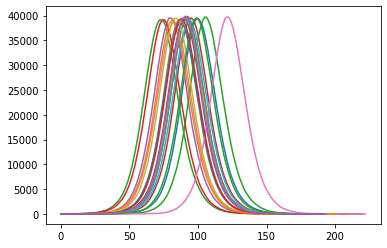

In [135]:
for stats in data.iloc[0]["stats"]:
    plt.plot(stats["is_infected"])


In [70]:
data = []
for i, (config_num, app_frac, rnd_test_prob) in enumerate(itertools.product(range(len(configs)), app_fractions, rnd_test_probs)):
    infile = "/scratch4/chaack/data/contagion/runs/1/config_{}.pickle".format(i)
    
    res = {
        "config": config_num,
        "app_frac": app_frac,
        "rnd_test_prob": rnd_test_prob,
        "stats": [res[0] for res in pickle.load(open(infile, "rb"))["results"]]
    }
    data.append(res)
data = pd.DataFrame(data)
    
    

In [72]:
for conf, conf_grp in data.groupby("config"):
    with PdfPages(os.path.join(PICS, "scan_rnd_test_frac_app_prob_conf_{}.pdf".format(conf))) as pdf:
        for app_frac, app_frac_grp in conf_grp.groupby("app_frac"):
            no_int = conf_grp.loc[(conf_grp["app_frac"] == 0) &  (conf_grp["rnd_test_prob"] == 0), "stats"].values
            results = np.concatenate((no_int, app_frac_grp["stats"].values))
            labels = ["No Interventions"] + ["Tests per Day: {:.0f}".format(rnd_test_prob*conf_1["population"]["population size"]) for rnd_test_prob in rnd_test_probs]
            fig = plot_scan(results, labels)
            fig.suptitle("App Prob: {:.2f}".format(app_frac))
            
            pdf.savefig(fig, bbox_inches="tight")
            #fig.savefig(os.path.join(PICS, "scan_rnd_test_frac_app_prob_{:.2f}.png".format(app_frac)), dpi=150)

            plt.close()
            
    

In [74]:
for conf, conf_grp in data.groupby("config"):
    with PdfPages(os.path.join(PICS, "scan_rnd_test_frac_app_prob_avg_re_conf_{}.pdf".format(conf))) as pdf:
        for app_frac, app_frac_grp in conf_grp.groupby("app_frac"):
            no_int = conf_grp.loc[(conf_grp["app_frac"] == 0) &  (conf_grp["rnd_test_prob"] == 0), "stats"].values
            results = np.concatenate((no_int, app_frac_grp["stats"].values))
            labels = ["No Interventions"] + ["Tests per Day: {:.0f}".format(rnd_test_prob*conf_1["population"]["population size"]) for rnd_test_prob in rnd_test_probs]
            fig = plot_avg_re_scan(results, labels)
            fig.suptitle("App Prob: {:.2f}".format(app_frac))
            
            pdf.savefig(fig, bbox_inches="tight")
            #fig.savefig(os.path.join(PICS, "scan_rnd_test_frac_app_prob_{:.2f}.png".format(app_frac)), dpi=150)

            plt.close()
            
    

In [51]:
infiles = ["/scratch4/chaack/data/contagion/runs/1/config_{}.pickle".format(i) for i in range(10)]
results = []
for f in infiles:
    results.append(pickle.load(open(f, "rb"))["results"][0])

In [ ]:
labels = ["No Interventions"] + ["Tests per Day: {:.0f}".format(rnd_test_prob*conf_1["population"]["population size"]) for rnd_test_prob in rnd_test_probs]
fig = plot_scan(results, labels)

In [ ]:
client = Client(scheduler_file="scheduler.json")
client.restart()
rnd_test_probs = np.concatenate(([0], np.logspace(-2, 0, 10)))
app_fractions = np.linspace(0, 1, 11)
all_results = []
for config in configs:
    all_futures = []
    for app_frac, rnd_test_prob in itertools.product(app_fractions, rnd_test_probs):
        conf = deepcopy(config)
        conf["measures"]["contact tracing"] = app_frac != 0
        conf["measures"]["app fraction"] = app_frac
        conf["measures"]["rnd testing"] = rnd_test_prob != 0
        conf["measures"]["random test num"] = int(rnd_test_prob * conf["population"]["population size"])
        conf["measures"]["test false positive rate"] = 0
        conf["measures"]["backtrack length"] = 7
        if not os.path.exists(conf["population"]["population storage"]):
            conf["population"]["store population"] = True
            #my_config["population"]["population storage"] = "1E6_lfr_ba.pickle"
            conf["population"]["re-use population"] = False
            contagion = Contagion(conf)
        conf["population"]["re-use population"] = True
        conf["population"]["store population"] = False

        futures = []
        for i in range(25):
            conf["general"]["random state seed"] = i
            futures.append(client.submit(calc_single, conf, pure=False))
        
        all_futures.append(futures)
    results = client.gather(all_futures, errors="skip")
    all_results.append(results)
all_results_arr = np.asarray(all_results)

In [17]:
len(all_results_arr)

NameError: name 'all_results_arr' is not defined

In [ ]:
while True:
    for i, fut in enumerate(all_futures):
        if fut.done() and not fut in result_dict:
            if fut.status == "error":
                fut.retry()
            else:
                result_dict[i] = fut.result()
    

In [17]:
len(all_results)

6

In [18]:
for i, all_res in enumerate(all_results_arr):
    with PdfPages(os.path.join(PICS, "scan_rnd_test_frac_app_prob_conf_{}.pdf".format(i))) as pdf:
        for j, app_frac in enumerate(app_fractions):
            results = all_res[j*len(rnd_test_probs):(j+1)*len(rnd_test_probs), :, 0]
            results = np.vstack((all_res[0, :, 0][np.newaxis, :], results))
            labels = ["No Interventions"] + ["Tests per Day: {:.0f}".format(rnd_test_prob*conf_1["population"]["population size"]) for rnd_test_prob in rnd_test_probs]
            fig = plot_scan(results, labels)
            fig.suptitle("App Prob: {:.2f}".format(app_frac))
            
            pdf.savefig(fig, bbox_inches="tight")
            #fig.savefig(os.path.join(PICS, "scan_rnd_test_frac_app_prob_{:.2f}.png".format(app_frac)), dpi=150)

            plt.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [299]:
for i, all_res in enumerate(all_results_arr):
    with PdfPages(os.path.join(PICS, "scan_rnd_test_frac_app_prob_avg_re.pdf")) as pdf:
        for j, app_frac in enumerate(app_fractions):
            results = all_res[j*len(rnd_test_probs):(j+1)*len(rnd_test_probs), :, 0]
            results = np.vstack((all_res[0, :, 0][np.newaxis, :], results))
            labels = ["No Interventions"] + ["Tests per Day: {:.0f}".format(rnd_test_prob*conf_1["population"]["population size"]) for rnd_test_prob in rnd_test_probs]

            fig = plot_avg_re_scan(results, labels)

            fig.suptitle("App Prob: {:.2f}".format(app_frac))
            pdf.savefig(fig, bbox_inches="tight")
            #fig.savefig(os.path.join(PICS, "scan_rnd_test_frac_app_prob_{:.2f}.png".format(app_frac)), dpi=150)

            plt.close()

In [ ]:
results = all_results_arr[0, 10, :, 0]

fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
for res in results:
    threshold = np.argwhere(res["is_infected"].values > 400)
    if len(threshold) > 0:
        trigger = res["is_infected"].values / 1E5 > 0.004
                
        if np.any(trigger):
            ax1.plot(res["is_infected"])
            ax2.plot(res["Re"])
            t_start = np.argwhere(trigger)[0][0]+7
            t_stop = min(t_start+14, len(result))
            print(t_start, t_stop)
            #avg_res.append(np.average(result["Re"].values[t_start:t_stop]))
            ax1.axvline(t_start, color="k")
            ax1.axvline(t_stop, color="k")
            ax2.axvline(t_start, color="k")
            ax2.axvline(t_stop, color="k")
            
            break
ax2.set_ylim(0.2, 2.5)
ax2.axhline(1, color="r")
ax1.set_ylabel("Infected")
ax2.set_ylabel("Re")

[0.17399713 0.17399713 0.17399713 0.17399713 0.17399713 0.17399713]
[0.17399713 0.17399713 0.17399713 0.17399713 0.17399713 0.17399713]
[0.17399713 0.17399713 0.17399713 0.17399713 0.17399713 0.17399713]
[0.17399713 0.17399713 0.17399713 0.17399713 0.17399713 0.17399713]
[0.17399713 0.17399713 0.17399713 0.17399713 0.17399713 0.17399713]
[0.17399713 0.17399713 0.17399713 0.17399713 0.17399713 0.17399713]


Text(0, 0.5, 'R0')

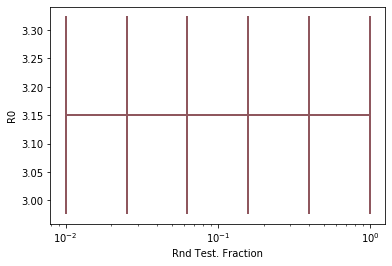

In [145]:
for i, app_frac in enumerate(app_fractions):
    r0 = all_results_arr[i*len(rnd_test_probs):(i+1)*len(rnd_test_probs), :, 1].astype(np.float)
    
    avg = np.average(r0, axis=1)
    q16 = np.percentile(r0, 16, axis=1)
    q84 = np.percentile(r0, 84, axis=1)
    std = np.std(r0, axis=1)
    plt.errorbar(rnd_test_probs, avg, yerr=std / np.sqrt(r0.shape[1]))
    print(std / np.sqrt(r0.shape[1]))
plt.semilogx()
plt.xlabel("Rnd Test. Fraction")
plt.ylabel("R0")

In [24]:
client = Client(scheduler_file="scheduler.json")
client.restart()
all_futures = []
for config in configs:
    conf = deepcopy(config)
    conf["measures"]["contact tracing"] = False
    conf["measures"]["app fraction"] = 0
    conf["measures"]["rnd testing"] = False
    conf["measures"]["random test num"] = 0
    conf["measures"]["test false positive rate"] = 0
    conf["measures"]["backtrack length"] = 7
    conf["population"]["re-use population"] = True
    conf["population"]["store population"] = False

    futures = []
    for i in range(25):
        conf["general"]["random state seed"] = i
        futures.append(client.submit(calc_single, conf, pure=False))
    all_futures.append(futures)
    
results_no_meas = client.gather(all_futures)

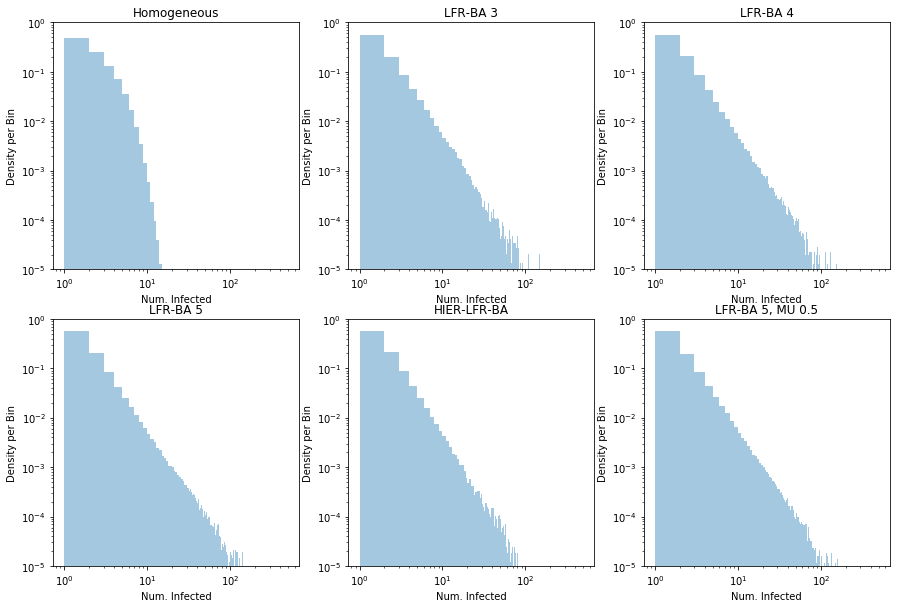

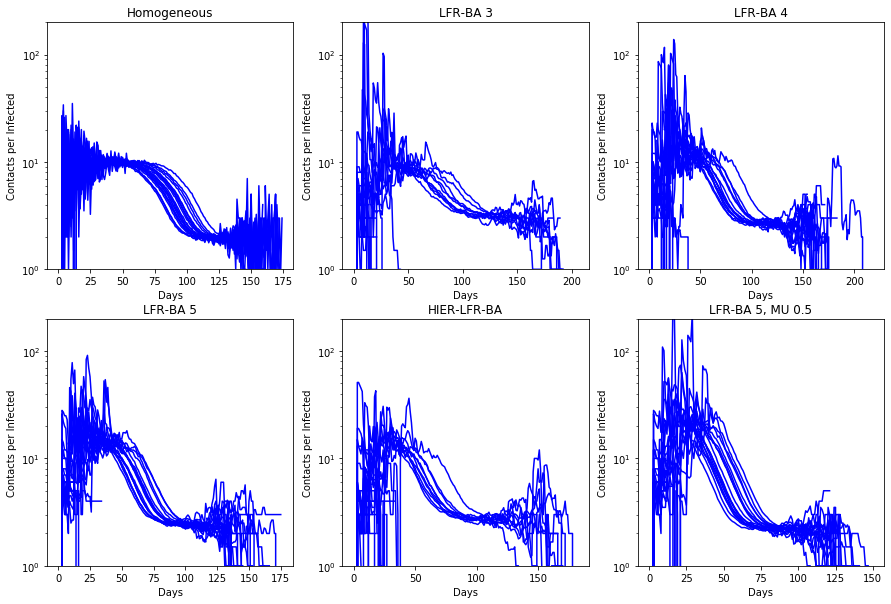

In [37]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig2, axs2 = plt.subplots(2, 3, figsize=(15, 10))
labels = ["Homogeneous", "LFR-BA 3", "LFR-BA 4", "LFR-BA 5", "HIER-LFR-BA", "LFR-BA 5, MU 0.5"]
for res, label, ax, ax2 in zip(results_no_meas, labels, axs.ravel(), axs2.ravel()):
    res = np.asarray(res)
    sns.distplot(np.concatenate(res[:, 2]), kde=False, norm_hist=True, label=label, bins=np.arange(0, 500), ax=ax)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_title(label)
    ax.set_ylim(1E-5, 1)
    ax.set_xlabel("Num. Infected")
    ax.set_ylabel("Density per Bin")
    
    for result in res:
        ax2.plot(result[0]["contacts_per_person"], color="blue")
    ax2.set_ylabel("Contacts per Infected")
    ax2.set_xlabel("Days")
    ax2.set_yscale("log")
    ax2.set_title(label)
    ax2.set_ylim(1, 2E2)

fig.savefig(os.path.join(PICS, "graph_comp_inf_per_inf.png"), bbox_inches="tight", dpi=150)
fig2.savefig(os.path.join(PICS, "graph_comp_contacts_per_p.png"), bbox_inches="tight", dpi=150)

In [101]:
client = Client(scheduler_file="scheduler.json")
client.restart()
rnd_test_probs = np.concatenate(([0], np.logspace(-2, 0, 10)))
app_fractions = np.linspace(0, 1, 11)
modes = [
    #"lin weight",
    "rnd"]
all_results = []
all_futures = []
for config in configs:    
    for app_frac, rnd_test_prob, test_mode in itertools.product(app_fractions, rnd_test_probs, modes):
        conf = deepcopy(config)
        conf["measures"]["contact tracing"] = app_frac != 0
        conf["measures"]["app fraction"] = app_frac
        conf["measures"]["rnd testing"] = rnd_test_prob != 0
        conf["measures"]["random test num"] = int(rnd_test_prob * conf["population"]["population size"])
        conf["measures"]["test false positive rate"] = 0
        conf["measures"]["backtrack length"] = 7
        conf["measures"]["random testing mode"] = test_mode
        if not os.path.exists(conf["population"]["population storage"]):
            conf["population"]["store population"] = True
            #my_config["population"]["population storage"] = "1E6_lfr_ba.pickle"
            conf["population"]["re-use population"] = False
            contagion = Contagion(conf)
        conf["population"]["re-use population"] = True
        conf["population"]["store population"] = False

        for i in range(25):
            conf["general"]["random state seed"] = i
            all_futures.append(client.submit(calc_single, conf, pure=False))
 
    results = client.gather(all_futures)
    all_results.append(results)
all_results_arr = np.asarray(all_results)

TypeError: __init__() got an unexpected keyword argument 'as_dtype'

In [26]:
while True:
    for i, fut in enumerate(all_futures):
        if fut.done() and not fut in result_dict:
            if fut.status == "error":
                fut.retry()
            else:
                result_dict[i] = fut.result()
    

In [39]:
result_dict = {}
for i, fut in enumerate(all_futures):
    if fut.done() and not fut in result_dict:
        if fut.status == "error":
            fut.retry()
        else:
            result_dict[i] = fut.result()


In [75]:
all_results = []
all_results = np.asarray(list(result_dict.values())).reshape((11, 11, 2, 25, 3))

In [78]:
for i, mode in enumerate(modes):
    with PdfPages(os.path.join(PICS, "scan_rnd_test_frac_app_prob_lfrba_mode_{}.pdf".format(mode))) as pdf:        
        for j, app_frac in enumerate(app_fractions):
         
            results = all_results[j, :, i, :, 0]
            results = np.vstack((all_results[0, 0, i, :, 0][np.newaxis, :], results))
            labels = ["No Interventions"] + ["Tests per Day: {:.0f}".format(rnd_test_prob*conf_1["population"]["population size"]) for rnd_test_prob in rnd_test_probs]
            fig = plot_scan(results, labels)
            fig.suptitle("App Prob: {:.2f}".format(app_frac))
            
            pdf.savefig(fig, bbox_inches="tight")
            #fig.savefig(os.path.join(PICS, "scan_rnd_test_frac_app_prob_{:.2f}.png".format(app_frac)), dpi=150)

            plt.close()
            
    

In [ ]:
for i, mode in enumerate(modes):
    with PdfPages(os.path.join(PICS, "scan_rnd_test_frac_app_prob_lfrba_mode_{}.pdf".format(mode))) as pdf:        
        for j, app_frac in enumerate(app_fractions):
         
            results = all_results[j, :, i, :, 0]
            results = np.vstack((all_results[0, 0, i, :, 0][np.newaxis, :], results))
            labels = ["No Interventions"] + ["Tests per Day: {:.0f}".format(rnd_test_prob*conf_1["population"]["population size"]) for rnd_test_prob in rnd_test_probs]
            fig = plot_scan(results, labels)
            fig.suptitle("App Prob: {:.2f}".format(app_frac))
            
            pdf.savefig(fig, bbox_inches="tight")
            #fig.savefig(os.path.join(PICS, "scan_rnd_test_frac_app_prob_{:.2f}.png".format(app_frac)), dpi=150)

            plt.close()
            
    

In [ ]:
all_results_arr = np.asrray(result_dict.values())
for i, all_res in enumerate(all_results_arr):
    
        for j, app_frac in enumerate(app_fractions):
            results = all_res[j*len(rnd_test_probs):(j+1)*len(rnd_test_probs), :, 0]
            results = np.vstack((all_res[0, :, 0][np.newaxis, :], results))
            labels = ["No Interventions"] + ["Tests per Day: {:.0f}".format(rnd_test_prob*conf_1["population"]["population size"]) for rnd_test_prob in rnd_test_probs]
            fig = plot_scan(results, labels)
            fig.suptitle("App Prob: {:.2f}".format(app_frac))
            
            pdf.savefig(fig, bbox_inches="tight")
            #fig.savefig(os.path.join(PICS, "scan_rnd_test_frac_app_prob_{:.2f}.png".format(app_frac)), dpi=150)

            plt.close()

In [21]:
fut = all_futures[0]

In [35]:
fut.status

'error'

In [47]:
a = nx.generators.barabasi_albert_graph(100, 3)
indices = np.asarray([3, 5, 7, 9])
print(a.degree)
si = sorted(indices, key=lambda i: a.degree[i], reverse=True)

[(0, 26), (1, 13), (2, 13), (3, 24), (4, 11), (5, 25), (6, 12), (7, 8), (8, 19), (9, 20), (10, 4), (11, 6), (12, 9), (13, 11), (14, 8), (15, 6), (16, 8), (17, 6), (18, 8), (19, 10), (20, 6), (21, 5), (22, 7), (23, 11), (24, 6), (25, 7), (26, 9), (27, 3), (28, 11), (29, 6), (30, 7), (31, 6), (32, 3), (33, 5), (34, 5), (35, 5), (36, 5), (37, 8), (38, 3), (39, 7), (40, 3), (41, 4), (42, 3), (43, 6), (44, 3), (45, 4), (46, 6), (47, 5), (48, 4), (49, 3), (50, 3), (51, 4), (52, 5), (53, 5), (54, 4), (55, 5), (56, 5), (57, 3), (58, 3), (59, 4), (60, 4), (61, 4), (62, 3), (63, 3), (64, 3), (65, 4), (66, 3), (67, 3), (68, 4), (69, 3), (70, 3), (71, 3), (72, 3), (73, 3), (74, 3), (75, 3), (76, 3), (77, 3), (78, 3), (79, 4), (80, 3), (81, 4), (82, 4), (83, 3), (84, 3), (85, 4), (86, 3), (87, 3), (88, 3), (89, 3), (90, 3), (91, 3), (92, 3), (93, 3), (94, 3), (95, 3), (96, 3), (97, 3), (98, 3), (99, 3)]


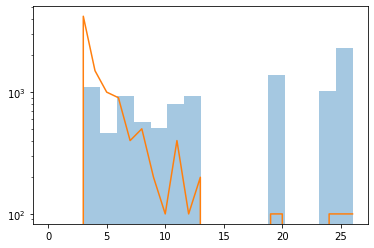

In [76]:
weights = np.asarray((list(dict(a.degree).values())))**2
weights = weights / weights.sum()
rnd = np.random.choice(np.arange(len(a)), size=10000, p=weights, replace=True)
sns.distplot([a.degree(i) for i in rnd], kde=False)
plt.semilogy()
deg_hist = np.asarray(nx.degree_histogram(a))
plt.plot(deg_hist*100)

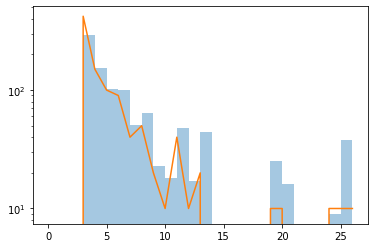

In [135]:
all_futures = []
for rnd_test_prob in rnd_test_probs:
    conf = deepcopy(conf_1)
    conf["measures"]["app fraction"] = 0
    conf["measures"]["contact tracing"] = False
    conf["measures"]["rnd testing"] = True
    conf["measures"]["random test num"] = int(rnd_test_prob * conf["population"]["population size"])
    conf["measures"]["test false positive rate"] = 0
    conf["measures"]["backtrack length"] = 7
    if not os.path.exists(conf["population"]["population storage"]):
        conf["population"]["store population"] = True
        #my_config["population"]["population storage"] = "1E6_lfr_ba.pickle"
        conf["population"]["re-use population"] = False
        contagion = Contagion(conf)
    conf["population"]["re-use population"] = True
    conf["population"]["store population"] = False
    
    futures = []
    for i in range(50):
        conf["general"]["random state seed"] = i
        futures.append(client.submit(calc_single, conf, pure=False))
    all_futures.append(futures)
all_results = client.gather(all_futures)
all_results_arr = np.asarray(all_results)

In [137]:
all_results_arr.shape

(6, 50, 2)

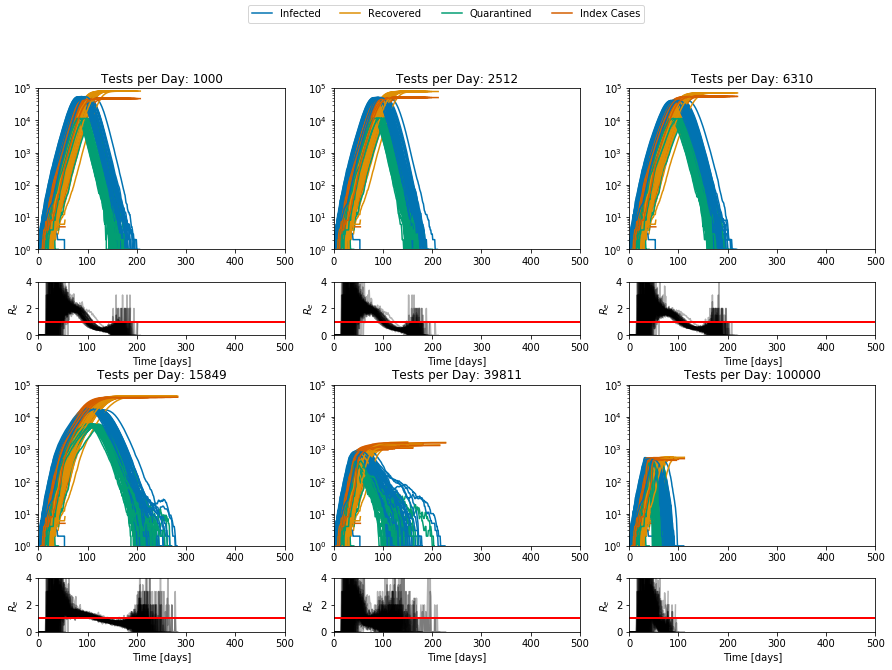

In [140]:
labels = ["Tests per Day: {:.0f}".format(rnd_test_prob*conf_1["population"]["population size"]) for rnd_test_prob in rnd_test_probs]
fig = plot_scan(all_results_arr[:, :, 0], labels)
fig.savefig(os.path.join(PICS, "scan_rnd_test_frac_no_tracing_prob.pdf"))

Text(0, 0.5, 'R0')

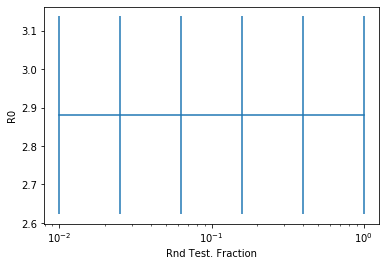

In [139]:

r0 = all_results_arr[:, :, 1].astype(np.float)

avg = np.average(r0, axis=1)
q16 = np.percentile(r0, 16, axis=1)
q84 = np.percentile(r0, 84, axis=1)
std = np.std(r0, axis=1)
plt.errorbar(rnd_test_probs, avg, yerr=std / np.sqrt(r0.shape[1]))
plt.semilogx()
plt.xlabel("Rnd Test. Fraction")
plt.ylabel("R0")

In [57]:

fig = plot_scan(all_results, labels)
fig.savefig(os.path.join(PICS, "index_cases_app_prob_0.5_rnd_test_scan.png"), dpi=150)

NameError: name 'conf_test' is not defined

In [51]:
all_futures = []
app_probs = np.linspace(0.1, 1, 6)
for app_prob in app_probs:
    conf = deepcopy(conf_1)
    conf["measures"]["app fraction"] = app_prob
    conf["measures"]["rnd testing"] = False
    conf["measures"]["random test prob"] = 0
    conf["measures"]["test false positive rate"] = 0
    conf["measures"]["backtrack length"] = 7

    if not os.path.exists(conf["population"]["population storage"]):
        conf["population"]["store population"] = True
        #my_config["population"]["population storage"] = "1E6_lfr_ba.pickle"
        conf["population"]["re-use population"] = False
        contagion = Contagion(conf)
    conf["population"]["re-use population"] = True
    conf["population"]["store population"] = False
    
    futures = []
    for i in range(50):
        conf["general"]["random state seed"] = i
        futures.append(client.submit(calc_single, conf, pure=False))
    all_futures.append(futures)
all_results = client.gather(all_futures)

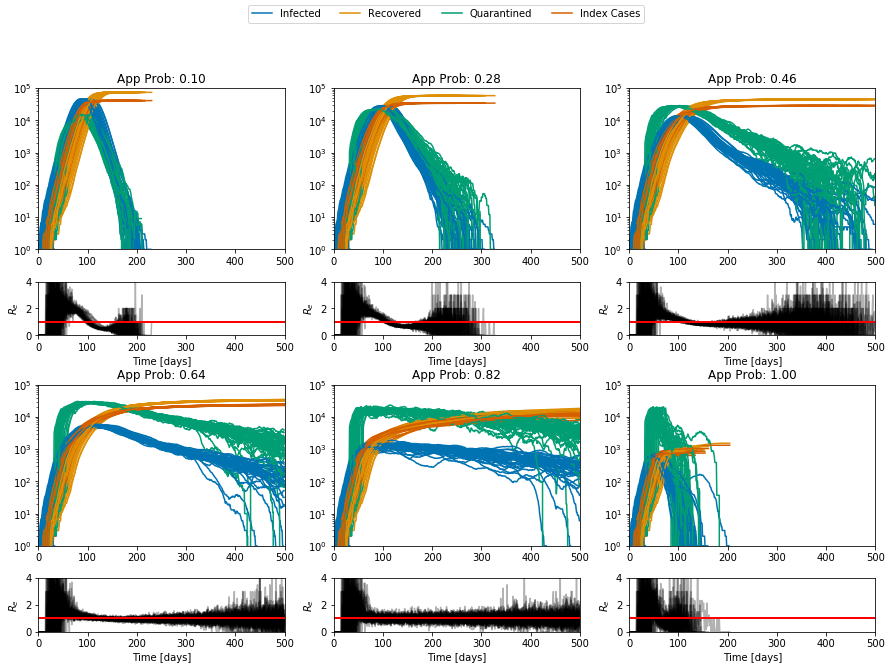

In [55]:
labels = ["App Prob: {:.2f}".format(app_prob) for app_prob in app_probs]
fig = plot_scan(all_results, labels)
fig.savefig(os.path.join(PICS, "index_cases_app_prob_rnd_test_false.png"), dpi=150)

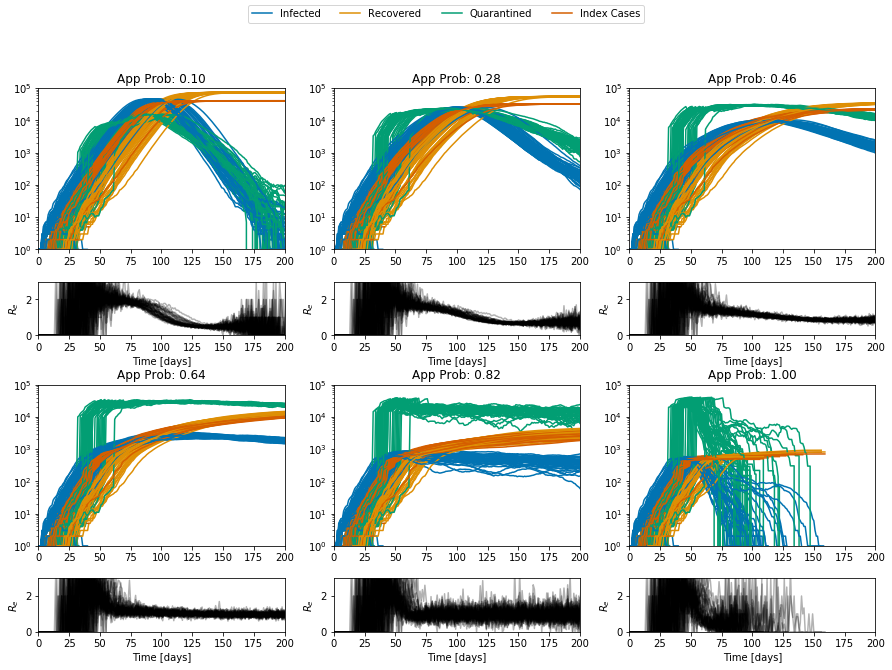

In [50]:
fig = plt.figure(figsize=(15, 10))
colors = sns.color_palette("colorblind", 4)


gs = gridspec.GridSpec(2, 3)

for i, (results, label) in enumerate(zip(all_results, labels)):
    
    gs_spec = gs[i // 3, i % 3]
    
    gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, gs_spec, height_ratios=[3, 1], hspace=0.3)
    ax = fig.add_subplot(gs2[0])
    ax2 = fig.add_subplot(gs2[1])
    
    for result in results:
        ax.plot(result["is_infected"], color=colors[0])
        ax.plot(result["is_recovered"], color=colors[1])
        ax.plot(result["is_quarantined"], color=colors[2])
        ax.plot(result["is_index_case"], color=colors[3])
        ax2.plot(result["Re"], color="k", alpha=0.3)
        
    ax2.set_xlabel("Time [days]")
    ax.set_title(label)
    ax.set_ylim(1, 1E5)
    ax.set_xlim(0, 200)
    ax.set_yscale("log")
    
    ax2.set_xlim(0, 200)
    ax2.set_ylim(0, 3)
    ax2.set_ylabel("$R_e$")
    
labels = ["Infected", "Recovered", "Quarantined", "Index Cases"]
proxies = [Line2D([], [], color=color) for color in colors]
fig.legend(proxies, labels, loc="upper center", ncol=4)


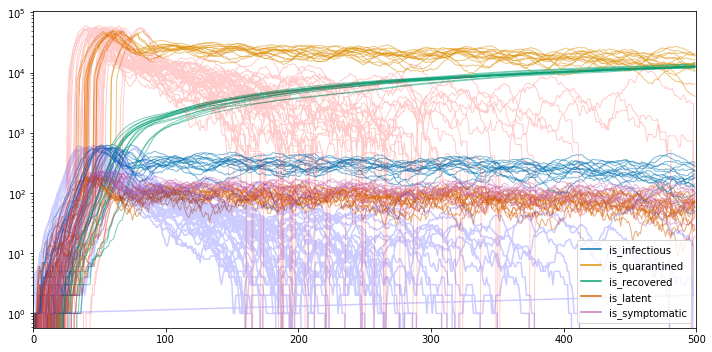

In [105]:
plt.figure(figsize=(10, 5))
colors = sns.color_palette("colorblind", 8)

fields = ["is_infectious", "is_quarantined", "is_recovered", "is_latent", "is_symptomatic"]

for stats in results:
    for field, color in zip(fields, colors):
        plt.plot(stats[field], color=color, lw=1, alpha=0.5)
proxies = []
for field, color in zip(fields, colors):
    proxies.append(Line2D([], [], label=field, color=color))
    
plt.legend(proxies, fields)
plt.semilogy()

plt.plot(data_cpp["day"], data_cpp[" fNInfectious"], color="b", alpha=0.2, )
plt.plot(data_cpp["day"], data_cpp[" fNQuarantineToday"], color="r", alpha=0.2, lw=1)

plt.xlim(0, 500)
plt.tight_layout()
plt.savefig("comp.png", dpi=150)

In [132]:
client = Client(scheduler_file="scheduler.json")
#client.restart()

In [29]:
conf = deepcopy(conf_3)
conf["population"]["re-use population"] = True
conf["population"]["store population"] = False
contagion = Contagion(conf)
g = contagion.pop._graph

In [30]:
np.average(list(dict(g.degree()).values()))

7.99794

In [36]:
client.restart()

Client Scheduler: tcp://10.152.133.30:39816 Dashboard: http://10.152.133.30:8787/status,Cluster Workers: 38 Cores: 38 Memory: 76.00 GB


In [42]:
all_futures = []
for config in configs:
    conf = deepcopy(config)
    if not os.path.exists(conf["population"]["population storage"]):
        conf["population"]["store population"] = True
        #my_config["population"]["population storage"] = "1E6_lfr_ba.pickle"
        conf["population"]["re-use population"] = False
        contagion = Contagion(conf)
    conf["population"]["re-use population"] = True
    conf["population"]["store population"] = False
    
    futures = []
    for i in range(50):
        conf["general"]["random state seed"] = i
        futures.append(client.submit(calc_single, conf, pure=False))
    all_futures.append(futures)
all_results = client.gather(all_futures)

In [44]:
sum_stats = []
for res in all_results:
    tot_infs = []
    for result in res:
        tot_inf_index = min(365, len(result["is_infected"])-1)
        tot_infs.append((result["is_infected"][tot_inf_index]+result["is_recovered"][tot_inf_index]+result["is_recovering"][tot_inf_index]))
    sum_stats.append(tot_infs)

In [18]:
for sstats in sum_stats:
    print(sstats)

[579, 618, 824, 762, 606, 659, 1, 591, 581, 620, 658, 751, 661, 3, 709, 574, 699, 626, 683, 622]
[28, 2, 1874, 2, 1, 5, 1, 52, 7, 6, 66, 3, 44, 3, 7, 1339, 5, 5, 1442, 2545]
[1699, 5, 75, 1, 25, 3, 1, 1459, 2, 107, 12, 821, 2, 6, 6, 3, 3, 7, 6, 2]
[21, 3, 8, 1, 15, 26, 1, 27, 32, 14, 7, 4, 16, 3, 1, 14, 2, 272, 139, 293]
[698, 20, 6, 1, 41, 740, 4, 1, 580, 1, 619, 631, 1, 2, 1, 595, 4, 1, 636, 2]
[4, 11, 2, 1, 1, 20, 21, 2, 2, 2, 40, 1, 2, 1, 1, 12, 3, 2, 8, 9]


In [23]:
data_cpp = pd.read_csv("Sum_CovidSimMC_1346.csv")

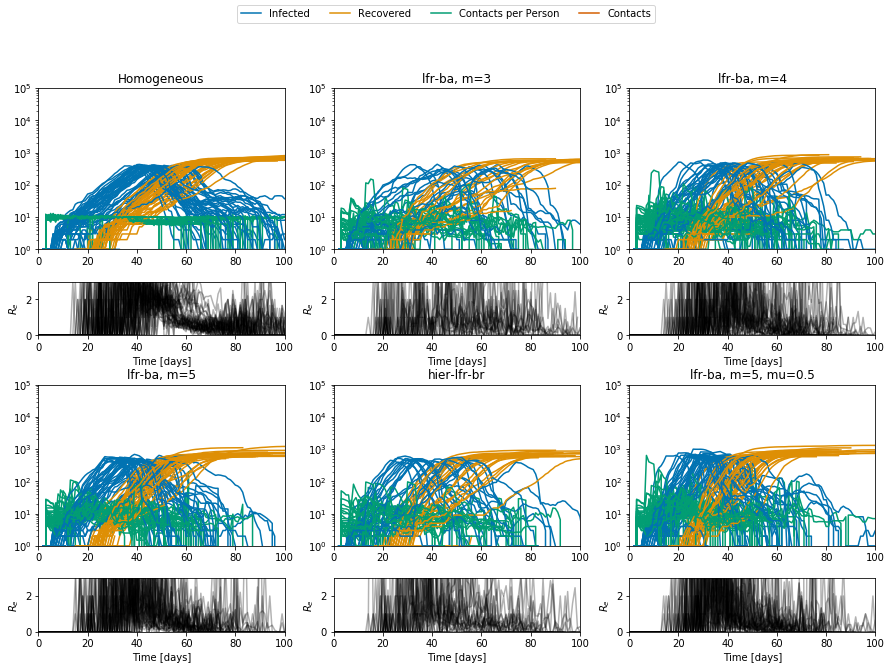

In [46]:
fig = plt.figure(figsize=(15, 10))
colors = sns.color_palette("colorblind", 4)
labels = ["Homogeneous", "lfr-ba, m=3", "lfr-ba, m=4", "lfr-ba, m=5", "hier-lfr-br", "lfr-ba, m=5, mu=0.5"]

gs = gridspec.GridSpec(2, 3)

for i, (res, label) in enumerate(zip(all_results, labels)):
    
    gs_spec = gs[i // 3, i % 3]
    
    gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, gs_spec, height_ratios=[3, 1], hspace=0.3)
    ax = fig.add_subplot(gs2[0])
    ax2 = fig.add_subplot(gs2[1])
    
    
    for result in res:
        ax.plot(result["is_infectious"], color=colors[0])
        ax.plot(result["is_recovered"], color=colors[1])
        ax.plot(result["contacts_per_person"], color=colors[2])
        #ax.plot(result["is_quarantined"], color=colors[2])
        #ax.plot(result["contacts"], color=colors[3])
        
        #ax.plot(data_cpp["day"], data_cpp[" fNInfectious"], color=colors[0], ls="--", alpha=0.3)
        #ax.plot(data_cpp["day"], data_cpp[" fNRecovered"], color=colors[1], ls="--", alpha=0.3)
        ax2.plot(result["Re"], color="k", alpha=0.3)
    ax2.set_xlabel("Time [days]")
    ax.set_title(label)
    ax.set_ylim(1, 1E5)
    ax.set_xlim(0, 100)
    ax.set_yscale("log")
    
    ax2.set_xlim(0, 100)
    ax2.set_ylim(0, 3)
    ax2.set_ylabel("$R_e$")
    

    
labels = ["Infected", "Recovered", "Contacts per Person", "Contacts", "Quarantined"]
proxies = [Line2D([], [], color=color) for color in colors]
fig.legend(proxies, labels, loc="upper center", ncol=4)
plt.savefig(os.path.join(PICS, "social_graph_comp.png"), dpi=150)

In [36]:
for conf in configs:
    conf["population"]["re-use population"] = True
    conf["population"]["store population"] = False
    
    contagion = Contagion(conf)
    if hasattr(contagion.pop, "_graph"):
        graph = contagion.pop._graph
        plt.plot(nx.degree_histogram(graph))
    print(nx.average_shortest_path_length(graph))
plt.loglog()

KeyboardInterrupt: 

In [191]:
conf = deepcopy(conf_2)

conf["population"]["re-use population"] = False
contagion = Contagion(conf)


(0.0001, 1)

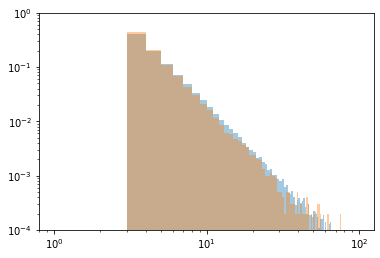

In [197]:
g = contagion.pop._graph
sns.distplot(list(dict(g.degree).values()), kde=False, norm_hist=True, bins=np.arange(1, 100))
a = construct_pdf({
            "class": "Pareto",
            "x_min": 3,
            "index": 2,
        })
sns.distplot(a.rvs(10000), kde=False, norm_hist=True, bins=np.arange(1, 100))
plt.loglog()
plt.ylim(1E-4, 1)

In [ ]:
networkx.algorithms.connectivity.kcomponents.k_components

In [ ]:
contagion = Contagion(conf_4)